In [1]:
%%capture --no-stderr
%pip install -U langgraph


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [11]:
from typing import Annotated, Literal

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI()
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

def select_next_node(state: State) -> Literal["human", "tools", "__end__"]:
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver()

graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

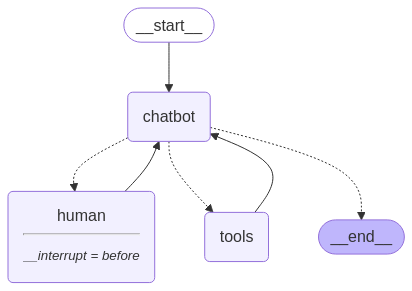

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_qlIqXZ2fjQKe6dj3op6jDJyJ)
 Call ID: call_qlIqXZ2fjQKe6dj3op6jDJyJ
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph Quickstart - GitHub Pages", "url": "https://langchain-ai.github.io/langgraph/tutorials/introduction/", "content": "[](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-9-1)Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its

In [14]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent with LangGraph can open up a world of possibilities in AI development. If you need any assistance or guidance as you work on your project, feel free to reach out. Good luck with building your autonomous agent with LangGraph!


In [15]:
config

{'configurable': {'thread_id': '1'}}

In [16]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 3:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [17]:
print(to_replay.next)
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f00d8ef-9c89-631f-8002-d0d4b05adb51'}}


In [18]:
# The `thread_ts` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph Quickstart - GitHub Pages", "url": "https://langchain-ai.github.io/langgraph/tutorials/introduction/", "content": "[](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-9-1)Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its components while adding graph-based coordination capabilities. It's particularly useful for developing more complex, [...] [](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-21-6)   LangGraph is a library designed for building stateful, multi-actor applications with Large Language Models (LLMs). It's particularly useful for creating agen